In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import importlib 
import src.var_net as var_net
import src.linear_var_hypernet as linear_var_hypernet
import src.base_net  as base_net
import src.utils as utils
importlib.reload(var_net)
importlib.reload(linear_var_hypernet)
importlib.reload(base_net)
importlib.reload(utils)
import json
from sklearn import decomposition

In [2]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [3]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 25 #количество эпох
hidden_num = 50 # количество нейронов на скрытом слое
lamb = [0.001, 0.01, 0.1, 1,  10, 100]
start_num = 5

lambda_encode = t.log
lambda_sample_num = 5
path_to_save = 'mnist_final'

if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

/mnt/Memory/iad/VarHyperNet/code/src/var_net.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
/mnt/Memory/iad/VarHyperNet/code/src/linear_var_hypernet.py:74: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  init_const)
/mnt/Memory/iad/VarHyperNet/code/src/linear_var_hypernet.py:76: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  init_const2)


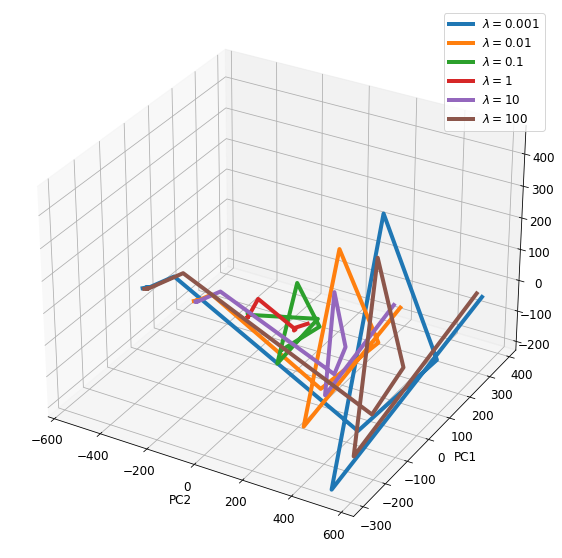

In [5]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x)).to(device)  
hnet = var_net.VarNet(linear_var_hypernet.VarLayerLinearAppr(784,  hidden_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
                         linear_var_hypernet.VarLayerLinearAppr(hidden_num, 10,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma)).to(device)    
net = net.to(device)
hnet = hnet.to(device)

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams.update({'font.size': 12})
plt.rc('lines', linewidth=4)
fig = plt.figure()
ax = fig.gca(projection='3d')
hnet.load_state_dict(t.load(os.path.join(path_to_save, 'rep_linear_start_1.cpk'))) 

for lam in lamb:       
    utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam))
    #net.load_state_dict(t.load(os.path.join(path_to_save, 'rep_net_lam_{}_start_1.cpk'.format(lam))))   
    pca = decomposition.PCA(n_components=3)
    res = t.tensor([])
    res = res.to(device)
    for i in [net[0].mean.data, net[0].mean_b.data, net[0].log_sigma.data,  net[0].log_sigma_b.data,
              net[1].mean.data, net[1].mean_b.data, net[1].log_sigma.data, net[1].log_sigma_b.data ]:
        fl = t.flatten(i)
        res = t.cat((res,fl))
    pca.fit(res.cpu().reshape(10, -1))
    res2 = pca.transform(res.cpu().reshape(10, -1))
    ax.plot(res2[:,0], res2[:,1], res2[:,2], label='$\lambda={}$'.format(lam))
plt.ylabel('PC1', fontsize = 12)
plt.xlabel('PC2', fontsize = 12)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('3D_rep_linear')
plt.show()
